In [1]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import xarray as xr

from osgeo import gdal
#from gistool import rasterize
import pyhdf
from pyhdf.SD import SD
import geopandas as gpd

from scipy import stats
from scipy import integrate
from numpy import exp
import math
from pymannkendall import original_test as mk

import matplotlib as mpl
import matplotlib.pyplot as plt
## set the line width of the hatch
mpl.rcParams['hatch.linewidth'] = 0.5
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
import matplotlib.ticker as mticker

In [8]:
ds0 = xr.open_dataset('/portal1/dell/li-b/NDVI/evi_m_qc_0.05.nc')

# exclude taiwan(120.5,122)(24.5,25.5) 
arr = ds0['vari'].values.copy()
arr[:,169:,200:] = np.nan
ds00 = xr.Dataset({'vari': (['time','lat','lon'], arr)},
                      coords={'time': (['time'], ds0.time.values), 
                              'lat': (['lat'], ds0.lat.values),
                      'lon': (['lon'], ds0.lon.values),})

ds1 = ds00

In [3]:
def cal_month_ano_aver(ds1, mon):
    ds_m0 = ds1.sel(time=ds1['time.month'].isin([mon]))
    ds_m = ds_m0['vari'].values

    anos = np.zeros_like(ds_m)

    for i in range(0,ds_m.shape[2]):
        for j in range(0,ds_m.shape[1]):
            v1 = ds_m[:,j,i]
            date = np.arange(2002,2023)
            
            non_nan_count = np.count_nonzero(~np.isnan(v1))
            if non_nan_count > 1:
                tr = mk(v1, alpha=0.05).trend
                if tr=='increasing':
                    pvalue=1
                    slo = stats.linregress(date,v1).slope
                    interc = stats.linregress(date,v1).intercept
                    trend = slo*date + interc
                    anos[:,j,i] = v1 - trend
                elif tr=='decreasing':
                    pvalue=-1
                    slo = stats.linregress(date,v1).slope
                    interc = stats.linregress(date,v1).intercept
                    trend = slo*date + interc
                    anos[:,j,i] = v1 - trend
                elif tr=='no trend':
                    pvalue=np.nan
                    anos[:,j,i] = v1 - v1.mean()
            else:
                anos[:,j,i] = v1 - v1.mean()
                
    ds_ano = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                        coords={'time': (['time'], ds_m0.time.values), 
                                'lat': (['lat'], ds_m0.lat.values),
                        'lon': (['lon'], ds_m0.lon.values),})
    return ds_ano

In [4]:
def cal_3month_ano_aver(ds1, mon1, mon2, mon3):
    ds_m0 = ds1.sel(time=ds1['time.month'].isin([mon1, mon2, mon3]))
    ds_m1 = ds_m0.groupby('time.year').mean(dim='time',skipna=True)
    ds_m = ds_m1['vari'].values

    anos = np.zeros_like(ds_m)

    for i in range(0,ds_m.shape[2]):
        for j in range(0,ds_m.shape[1]):
            v1 = ds_m[:,j,i]
            date = np.arange(2002,2023)
            
            non_nan_count = np.count_nonzero(~np.isnan(v1))
            if non_nan_count > 1:
                tr = mk(v1, alpha=0.05).trend
                if tr=='increasing':
                    pvalue=1
                    slo = stats.linregress(date,v1).slope
                    interc = stats.linregress(date,v1).intercept
                    trend = slo*date + interc
                    anos[:,j,i] = v1 - trend
                elif tr=='decreasing':
                    pvalue=-1
                    slo = stats.linregress(date,v1).slope
                    interc = stats.linregress(date,v1).intercept
                    trend = slo*date + interc
                    anos[:,j,i] = v1 - trend
                elif tr=='no trend':
                    pvalue=np.nan
                    anos[:,j,i] = v1 - v1.mean()
            else:
                anos[:,j,i] = v1 - v1.mean()
                
    ds_ano = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                        coords={'time': (['time'], ds_ano7.time.values), 
                                'lat': (['lat'], ds_m0.lat.values),
                        'lon': (['lon'], ds_m0.lon.values),})
    return ds_ano

In [9]:
ds_ano7 = cal_month_ano_aver(ds1, 7)
ds_ano8 = cal_month_ano_aver(ds1, 8)
ds_ano9 = cal_month_ano_aver(ds1, 9)
ds_ano789 = cal_3month_ano_aver(ds1, 7, 8, 9)

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [10]:
c7 = ds_ano7['vari'].mean(dim=['lat','lon'],skipna=True).values
c8 = ds_ano8['vari'].mean(dim=['lat','lon'],skipna=True).values
c9 = ds_ano9['vari'].mean(dim=['lat','lon'],skipna=True).values
c789 = ds_ano789['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range('2002','2023',freq='Y')
df1 = pd.DataFrame({'time':times,'jul_ano':c7,'agu_ano':c8,'sep_ano':c9,'jas_ano':c789})
df1

,time,jul_ano,agu_ano,sep_ano,jas_ano
0,2002-12-31,-0.014100,-0.013556,-0.015987,-0.012553
1,2003-12-31,-0.022415,-0.034559,-0.018143,-0.023477
2,2004-12-31,-0.008237,-0.010103,-0.020331,-0.009544
3,2005-12-31,-0.015000,-0.003005,-0.012660,-0.007133
4,2006-12-31,0.004166,0.006958,-0.007981,0.002804
5,2007-12-31,0.006189,-0.007951,-0.006473,-0.002036
6,2008-12-31,0.002987,0.003518,0.005715,0.005623
7,2009-12-31,0.000573,0.016158,0.000473,0.006890
8,2010-12-31,0.010742,0.010605,0.017861,0.013221
9,2011-12-31,-0.001673,0.011456,0.016859,0.010611


In [3]:
area = ds1.mean(dim=['lat','lon'],skipna=True) 
times = pd.date_range('2002-07-31', '2022-12-31', freq='M')
df = pd.DataFrame({'time':times,'vari':area['vari'].values})
df.set_index('time',inplace=True)

df_7 = df['vari'].loc[df.index.month==7].values
df_8 = df['vari'].loc[df.index.month==8].values
df_9 = df['vari'].loc[df.index.month==9].values
times = pd.date_range('2002','2023',freq='Y')

df1 = pd.DataFrame({'time':times,'jul':df_7,'agu':df_8,'sep':df_9})
df1['jas'] = (df1['jul'] + df1['agu'] + df1['sep'])/3
df1.set_index('time',inplace=True)

date = np.arange(2002,2023)
results = {}

for column in df1.columns:
    v1 = df1[column].values
    
    tr = mk(v1, alpha=0.05).trend
    if tr=='increasing':
        pvalue=1
        slo = stats.linregress(date,v1).slope
        interc = stats.linregress(date,v1).intercept
        trend = slo*date + interc
        df1[column+'_ano'] = df1[column].values - trend
    elif tr=='decreasing':
        pvalue=-1
        slo = stats.linregress(date,v1).slope
        interc = stats.linregress(date,v1).intercept
        trend = slo*date + interc
        df1[column+'_ano'] = df1[column].values - trend
    elif tr=='no trend':
        pvalue=np.nan
        df1[column+'_ano'] = df1[column].values - df1[column].values.mean() 
    
    results[column] = (slo, pvalue)
results

{'jul': (0.0022687308019708665, 1),
 'agu': (0.0013897558446199863, 1),
 'sep': (0.002064813606359302, 1),
 'jas': (0.0019077667509833876, 1)}

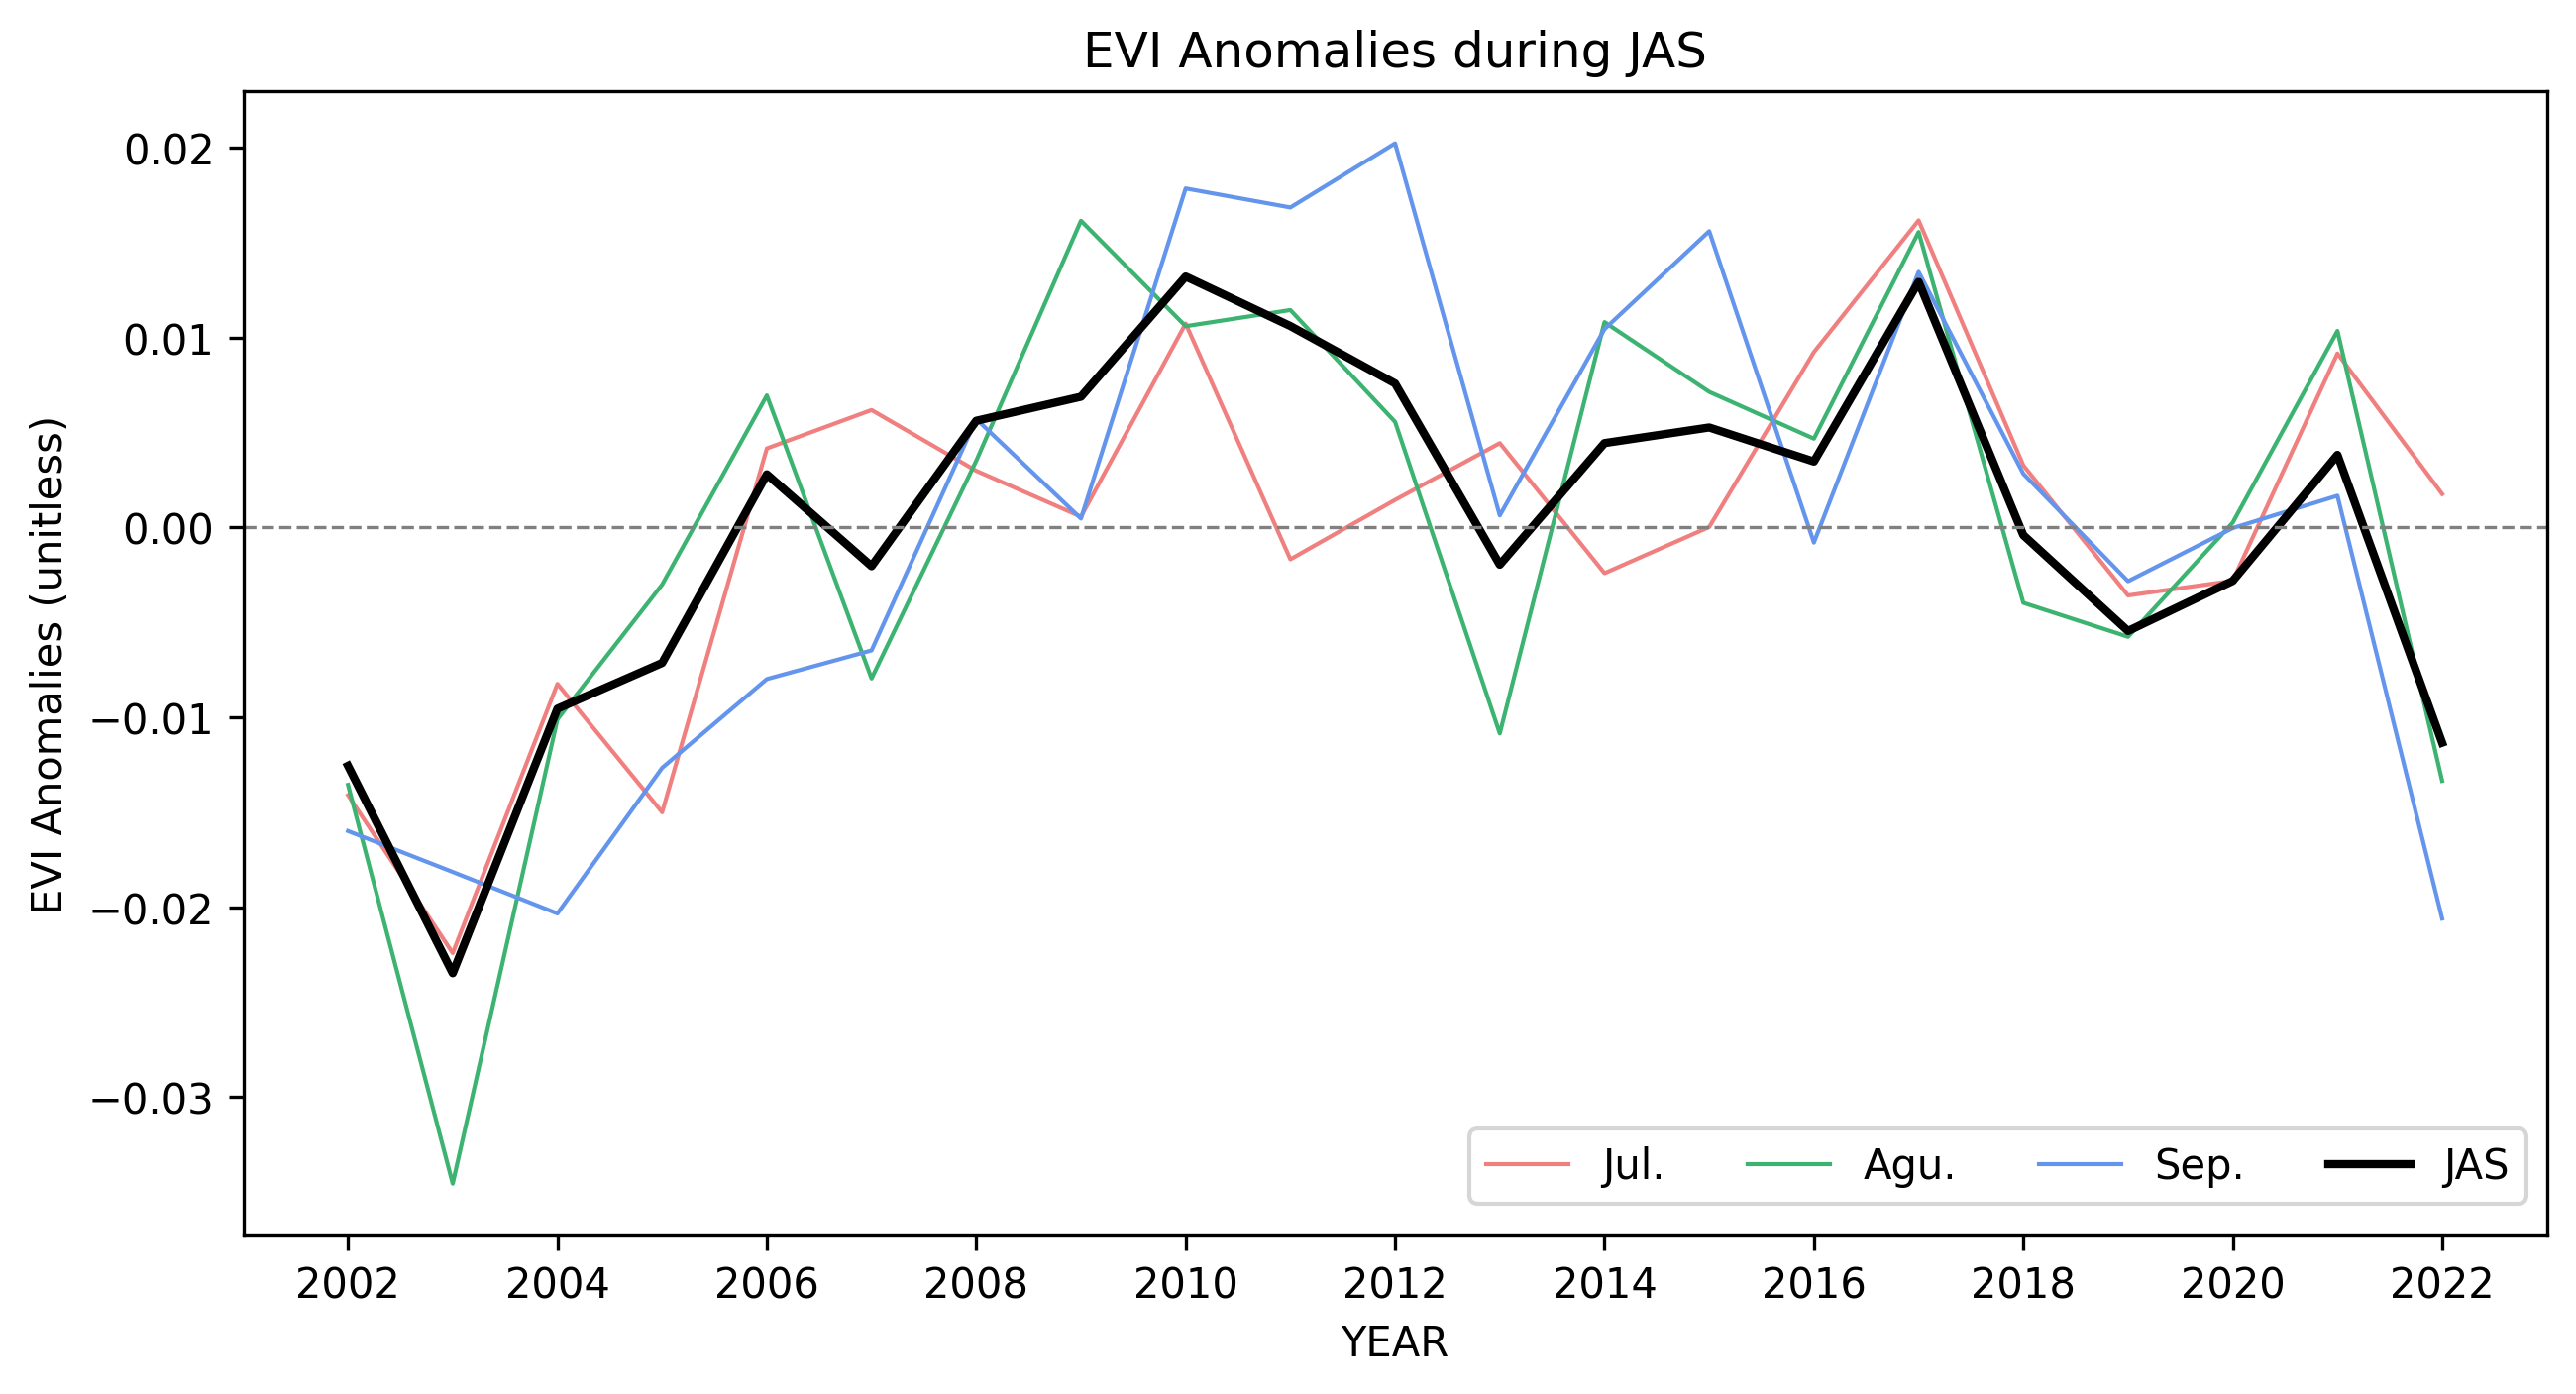

In [11]:
date = np.arange(2002,2023)
v1 = df1['jul_ano']
v2 = df1['agu_ano']
v3 = df1['sep_ano']
v4 = df1['jas_ano']

fig, ax = plt.subplots(1,1,dpi=300,figsize=(10,5))


ax.plot(date, v1,color='lightcoral',lw=1, ls='-', label='Jul.')
ax.plot(date, v2,color='mediumseagreen',lw=1, ls='-', label='Agu.')
ax.plot(date, v3,color='cornflowerblue',lw=1, ls='-', label='Sep.')
ax.plot(date, v4,color='black',lw=2, ls='-', label='JAS')

ax.set_ylabel('EVI Anomalies (unitless)')
#ax1.set_ylabel('PRR (%)')
ax.set_xlabel('YEAR')
custom_ticks = np.arange(2002, 2023, step=2)  # Define the tick locations
custom_tick_labels = [str(year) for year in custom_ticks]  # Define the tick labels

ax.set_xticks(custom_ticks)
ax.set_xticklabels(custom_tick_labels)

ax.axhline(y=0, color='gray', linestyle='--',lw=0.8)
    
#figname = filename.replace('.txt','')
ax.set_title('EVI Anomalies during JAS')
ax.set_xlim(date[0]-1, date[-1]+1)
fig.legend(loc="lower right", bbox_to_anchor=(1, 0.01), bbox_transform=ax.transAxes, ncol = 5)

#plt.savefig('D:/rice/figs/middleyield.png')                         
plt.show()

In [4]:
ds_m0 = ds1.sel(time=ds1['time.month'].isin([7]))
ds_m = ds_m0['vari'].values

anos = np.zeros_like(ds_m)

for i in range(0,ds_m.shape[2]):
    for j in range(0,ds_m.shape[1]):
        v1 = ds_m[:,j,i]
        date = np.arange(2002,2023)
        
        non_nan_count = np.count_nonzero(~np.isnan(v1))
        if non_nan_count > 1:
            tr = mk(v1, alpha=0.05).trend
            if tr=='increasing':
                pvalue=1
                slo = stats.linregress(date,v1).slope
                interc = stats.linregress(date,v1).intercept
                trend = slo*date + interc
                anos[:,j,i] = v1 - trend
            elif tr=='decreasing':
                pvalue=-1
                slo = stats.linregress(date,v1).slope
                interc = stats.linregress(date,v1).intercept
                trend = slo*date + interc
                anos[:,j,i] = v1 - trend
            elif tr=='no trend':
                pvalue=np.nan
                anos[:,j,i] = v1 - v1.mean()
        else:
            anos[:,j,i] = v1 - v1.mean()
            
data = anos[20,:,:]
ds_ano7 = xr.Dataset({'vari': (['lat','lon'], data)},
                      coords={ 'lat': (['lat'], ds_m0.lat.values),
                      'lon': (['lon'], ds_m0.lon.values),})
##################################################################################################
ds_m0 = ds1.sel(time=ds1['time.month'].isin([8]))
ds_m = ds_m0['vari'].values

anos = np.zeros_like(ds_m)

for i in range(0,ds_m.shape[2]):
    for j in range(0,ds_m.shape[1]):
        v1 = ds_m[:,j,i]
        date = np.arange(2002,2023)
        
        non_nan_count = np.count_nonzero(~np.isnan(v1))
        if non_nan_count > 1:
            tr = mk(v1, alpha=0.05).trend
            if tr=='increasing':
                pvalue=1
                slo = stats.linregress(date,v1).slope
                interc = stats.linregress(date,v1).intercept
                trend = slo*date + interc
                anos[:,j,i] = v1 - trend
            elif tr=='decreasing':
                pvalue=-1
                slo = stats.linregress(date,v1).slope
                interc = stats.linregress(date,v1).intercept
                trend = slo*date + interc
                anos[:,j,i] = v1 - trend
            elif tr=='no trend':
                pvalue=np.nan
                anos[:,j,i] = v1 - v1.mean()
        else:
            anos[:,j,i] = v1 - v1.mean()
            
data = anos[20,:,:]
ds_ano8 = xr.Dataset({'vari': (['lat','lon'], data)},
                      coords={ 'lat': (['lat'], ds_m0.lat.values),
                      'lon': (['lon'], ds_m0.lon.values),})

##############################################################################################
ds_m0 = ds1.sel(time=ds1['time.month'].isin([9]))
ds_m = ds_m0['vari'].values

anos = np.zeros_like(ds_m)

for i in range(0,ds_m.shape[2]):
    for j in range(0,ds_m.shape[1]):
        v1 = ds_m[:,j,i]
        date = np.arange(2002,2023)
        
        non_nan_count = np.count_nonzero(~np.isnan(v1))
        if non_nan_count > 1:
            tr = mk(v1, alpha=0.05).trend
            if tr=='increasing':
                pvalue=1
                slo = stats.linregress(date,v1).slope
                interc = stats.linregress(date,v1).intercept
                trend = slo*date + interc
                anos[:,j,i] = v1 - trend
            elif tr=='decreasing':
                pvalue=-1
                slo = stats.linregress(date,v1).slope
                interc = stats.linregress(date,v1).intercept
                trend = slo*date + interc
                anos[:,j,i] = v1 - trend
            elif tr=='no trend':
                pvalue=np.nan
                anos[:,j,i] = v1 - v1.mean()
        else:
            anos[:,j,i] = v1 - v1.mean()
            
data = anos[20,:,:]
ds_ano9 = xr.Dataset({'vari': (['lat','lon'], data)},
                      coords={ 'lat': (['lat'], ds_m0.lat.values),
                      'lon': (['lon'], ds_m0.lon.values),})

########################################################################################################
ds_m0 = ds1.sel(time=ds1['time.month'].isin([7,8,9]))
ds_m1 = ds_m0.groupby('time.year').mean(dim='time',skipna=True)
ds_m = ds_m1['vari'].values

anos = np.zeros_like(ds_m)

for i in range(0,ds_m.shape[2]):
    for j in range(0,ds_m.shape[1]):
        v1 = ds_m[:,j,i]
        date = np.arange(2002,2023)
        
        non_nan_count = np.count_nonzero(~np.isnan(v1))
        if non_nan_count > 1:
            tr = mk(v1, alpha=0.05).trend
            if tr=='increasing':
                pvalue=1
                slo = stats.linregress(date,v1).slope
                interc = stats.linregress(date,v1).intercept
                trend = slo*date + interc
                anos[:,j,i] = v1 - trend
            elif tr=='decreasing':
                pvalue=-1
                slo = stats.linregress(date,v1).slope
                interc = stats.linregress(date,v1).intercept
                trend = slo*date + interc
                anos[:,j,i] = v1 - trend
            elif tr=='no trend':
                pvalue=np.nan
                anos[:,j,i] = v1 - v1.mean()
        else:
            anos[:,j,i] = v1 - v1.mean()
            
data = anos[20,:,:]
ds_ano789 = xr.Dataset({'vari': (['lat','lon'], data)},
                      coords={ 'lat': (['lat'], ds_m0.lat.values),
                      'lon': (['lon'], ds_m0.lon.values),})

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [6]:
d7_0 = ds_ano7['vari'].values
box7 = d7_0[~np.isnan(d7_0)].ravel()

d8_0 = ds_ano8['vari'].values
box8 = d8_0[~np.isnan(d8_0)].ravel()

d9_0 = ds_ano9['vari'].values
box9 = d9_0[~np.isnan(d9_0)].ravel()

d789_0 = ds_ano789['vari'].values
box789 = d789_0[~np.isnan(d789_0)].ravel()

box = [box7,box8,box9,box789]
for i in box:
    lo = np.nanpercentile(i,q=25)
    up = np.nanpercentile(i,q=75)
    upbo = up+1.5*(up-lo)
    lobo = lo-1.5*(up-lo)
    maxmum = i.max()
    minmum = i.min()
    print(upbo, lobo, maxmum, minmum)

0.12023587612327546 -0.11640849553243526 0.24996665545872276 -0.21284974882698648
0.09643581715272093 -0.12481829274514838 0.22618831719510357 -0.2303895697711556
0.09260380451235455 -0.13753534670797368 0.2405800894225294 -0.23520193540014533
0.074506172093665 -0.0999648171708381 0.24868475272090185 -0.1997180299196983


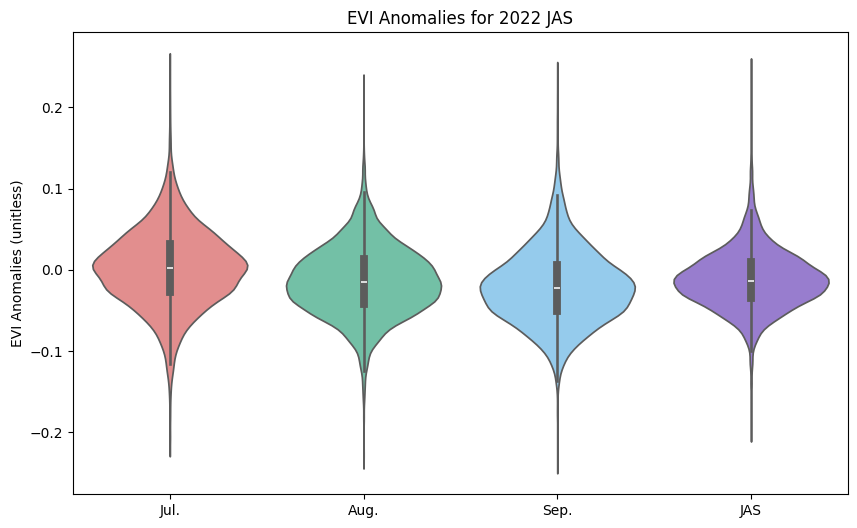

In [9]:
import seaborn as sns

data_to_plot = [box7, box8, box9, box789]
custom_palette = ["lightcoral", "mediumaquamarine", "lightskyblue", "mediumpurple"]
# Create a violin plot for all datasets in one figure
plt.figure(figsize=(10, 6))
sns.violinplot(data=data_to_plot, palette=custom_palette, inner='box')

# Customize the plot as needed
plt.title('EVI Anomalies for 2022 JAS')
# plt.xlabel('Datasets')
plt.ylabel('EVI Anomalies (unitless)')
custom_labels = ['Jul.', 'Aug.', 'Sep.','JAS']
plt.xticks(range(len(custom_labels)), custom_labels)
# Show the plot
plt.show()

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, '2022 Jul. EVI Anomalies')

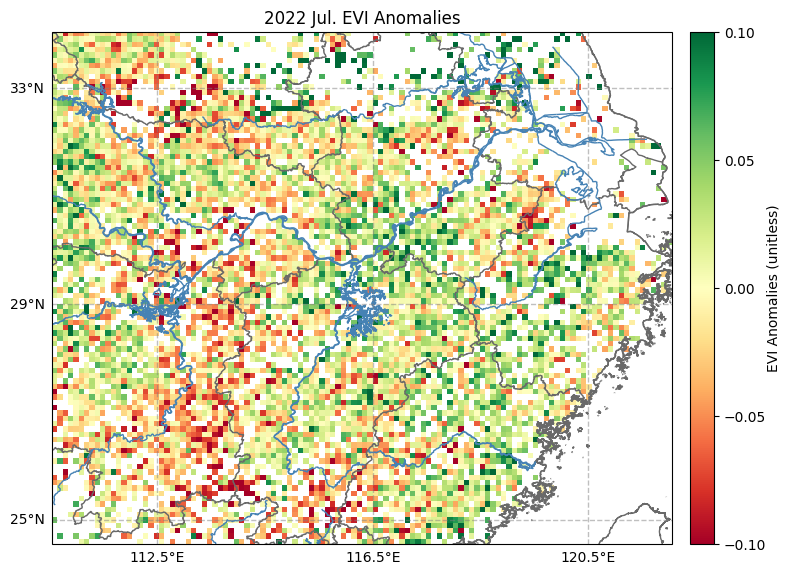

In [5]:
data = ds_ano7['vari'].values
gdf1 = gpd.read_file('/portal1/dell/li-b/meteo/bound.shp')
gdf2 = gpd.read_file('/portal1/dell/li-b/meteo/allrivers.shp')
latitude, longitude = ds_ano7.lat.values, ds_ano7.lon.values

vmax=0.1
vmin=-0.1
cmap = plt.get_cmap('RdYlGn')

projection = ccrs.PlateCarree()
# arr_flipped = np.flip(data, axis=0)
arr_flipped = data
fig, ax = plt.subplots(figsize=(8,10),subplot_kw={'projection': ccrs.PlateCarree()})
gdf1.plot(ax=ax, facecolor='none', edgecolor='dimgray', linewidth=1)
gdf2.plot(ax=ax, facecolor='none', edgecolor='steelblue', linewidth=1)
img = ax.imshow(arr_flipped, extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()],
                transform=projection,
                cmap=cmap,
                vmax=vmax,
                vmin=vmin)


ticks = list(np.linspace(vmin, vmax, 5))
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
pos = ax.get_position()
pad = 0.015*1.5
width = 0.015*2
clen = 0.6
cax = fig.add_axes([pos.xmax + pad, pos.ymin, width, (pos.ymax - pos.ymin)])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, extend='neither', orientation='vertical')
cbar.ax.set_ylabel('EVI Anomalies (unitless)')
cbar.set_ticks(ticks)
# Adjust the distance between colorbar label and colorbar
labelpad = 0.001  # Adjust this value as needed
cbar.ax.yaxis.labelpad = labelpad

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([112.5,116.5,120.5])
gl.ylocator = mticker.FixedLocator([25,29,33])

ax.set_title('2022 Jul. EVI Anomalies')

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, '2022 Agu. EVI Anomalies')

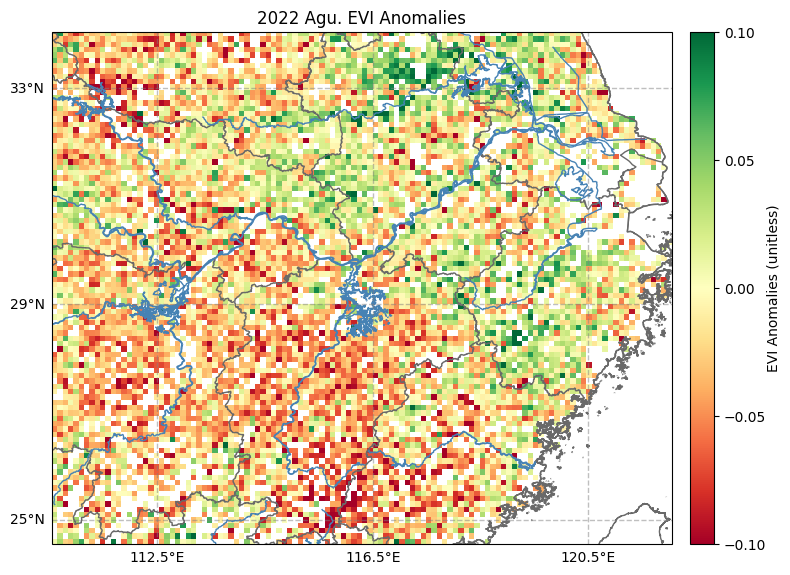

In [6]:
data = ds_ano8['vari'].values
gdf1 = gpd.read_file('/portal1/dell/li-b/meteo/bound.shp')
gdf2 = gpd.read_file('/portal1/dell/li-b/meteo/allrivers.shp')
latitude, longitude = ds_ano7.lat.values, ds_ano7.lon.values

vmax=0.1
vmin=-0.1
cmap = plt.get_cmap('RdYlGn')

projection = ccrs.PlateCarree()
# arr_flipped = np.flip(data, axis=0)
arr_flipped = data
fig, ax = plt.subplots(figsize=(8,10),subplot_kw={'projection': ccrs.PlateCarree()})
gdf1.plot(ax=ax, facecolor='none', edgecolor='dimgray', linewidth=1)
gdf2.plot(ax=ax, facecolor='none', edgecolor='steelblue', linewidth=1)
img = ax.imshow(arr_flipped, extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()],
                transform=projection,
                cmap=cmap,
                vmax=vmax,
                vmin=vmin)


ticks = list(np.linspace(vmin, vmax, 5))
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
pos = ax.get_position()
pad = 0.015*1.5
width = 0.015*2
clen = 0.6
cax = fig.add_axes([pos.xmax + pad, pos.ymin, width, (pos.ymax - pos.ymin)])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, extend='neither', orientation='vertical')
cbar.ax.set_ylabel('EVI Anomalies (unitless)')
cbar.set_ticks(ticks)
# Adjust the distance between colorbar label and colorbar
labelpad = 0.001  # Adjust this value as needed
cbar.ax.yaxis.labelpad = labelpad

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([112.5,116.5,120.5])
gl.ylocator = mticker.FixedLocator([25,29,33])

ax.set_title('2022 Agu. EVI Anomalies')

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, '2022 Sep. EVI Anomalies')

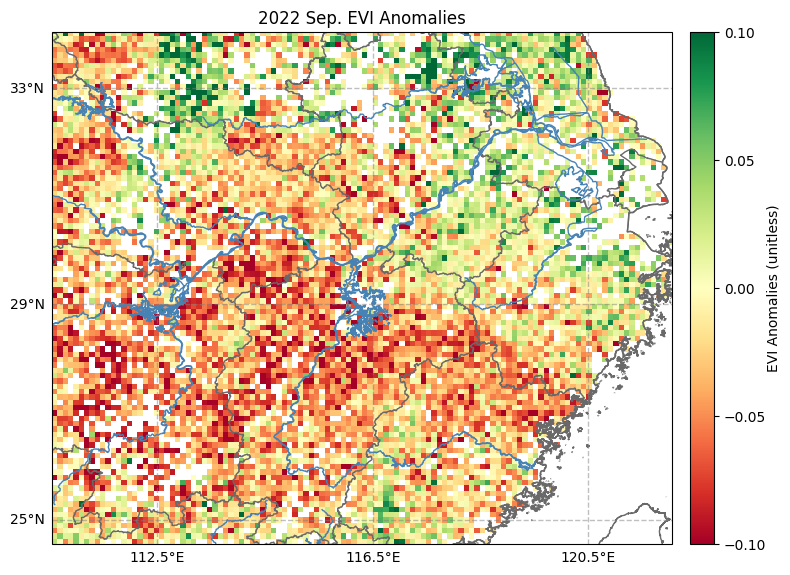

In [7]:
data = ds_ano9['vari'].values
gdf1 = gpd.read_file('/portal1/dell/li-b/meteo/bound.shp')
gdf2 = gpd.read_file('/portal1/dell/li-b/meteo/allrivers.shp')
latitude, longitude = ds_ano7.lat.values, ds_ano7.lon.values

vmax=0.1
vmin=-0.1
cmap = plt.get_cmap('RdYlGn')

projection = ccrs.PlateCarree()
# arr_flipped = np.flip(data, axis=0)
arr_flipped = data
fig, ax = plt.subplots(figsize=(8,10),subplot_kw={'projection': ccrs.PlateCarree()})
gdf1.plot(ax=ax, facecolor='none', edgecolor='dimgray', linewidth=1)
gdf2.plot(ax=ax, facecolor='none', edgecolor='steelblue', linewidth=1)
img = ax.imshow(arr_flipped, extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()],
                transform=projection,
                cmap=cmap,
                vmax=vmax,
                vmin=vmin)


ticks = list(np.linspace(vmin, vmax, 5))
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
pos = ax.get_position()
pad = 0.015*1.5
width = 0.015*2
clen = 0.6
cax = fig.add_axes([pos.xmax + pad, pos.ymin, width, (pos.ymax - pos.ymin)])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, extend='neither', orientation='vertical')
cbar.ax.set_ylabel('EVI Anomalies (unitless)')
cbar.set_ticks(ticks)
# Adjust the distance between colorbar label and colorbar
labelpad = 0.001  # Adjust this value as needed
cbar.ax.yaxis.labelpad = labelpad

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([112.5,116.5,120.5])
gl.ylocator = mticker.FixedLocator([25,29,33])

ax.set_title('2022 Sep. EVI Anomalies')

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, '2022 JAS EVI Anomalies')

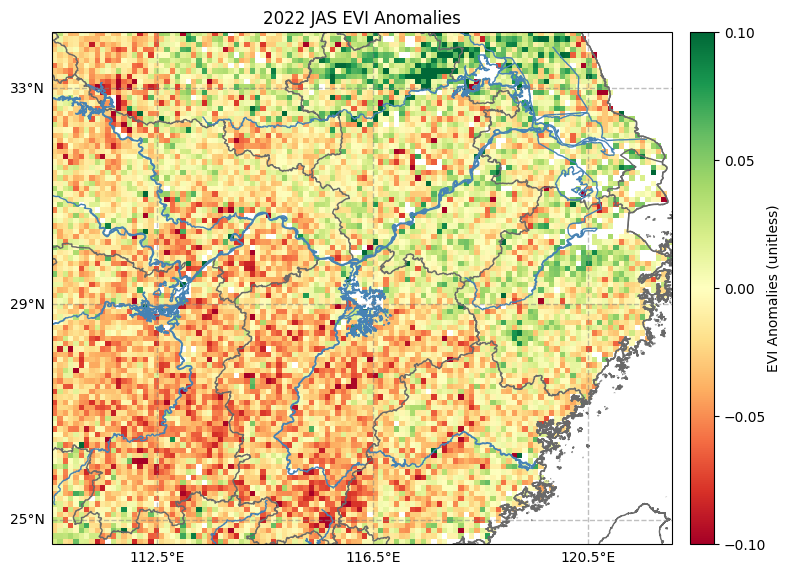

In [8]:
data = ds_ano789['vari'].values
gdf1 = gpd.read_file('/portal1/dell/li-b/meteo/bound.shp')
gdf2 = gpd.read_file('/portal1/dell/li-b/meteo/allrivers.shp')
latitude, longitude = ds_ano7.lat.values, ds_ano7.lon.values

vmax=0.1
vmin=-0.1
cmap = plt.get_cmap('RdYlGn')

projection = ccrs.PlateCarree()
# arr_flipped = np.flip(data, axis=0)
arr_flipped = data
fig, ax = plt.subplots(figsize=(8,10),subplot_kw={'projection': ccrs.PlateCarree()})
gdf1.plot(ax=ax, facecolor='none', edgecolor='dimgray', linewidth=1)
gdf2.plot(ax=ax, facecolor='none', edgecolor='steelblue', linewidth=1)
img = ax.imshow(arr_flipped, extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()],
                transform=projection,
                cmap=cmap,
                vmax=vmax,
                vmin=vmin)


ticks = list(np.linspace(vmin, vmax, 5))
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
pos = ax.get_position()
pad = 0.015*1.5
width = 0.015*2
clen = 0.6
cax = fig.add_axes([pos.xmax + pad, pos.ymin, width, (pos.ymax - pos.ymin)])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, extend='neither', orientation='vertical')
cbar.ax.set_ylabel('EVI Anomalies (unitless)')
cbar.set_ticks(ticks)
# Adjust the distance between colorbar label and colorbar
labelpad = 0.001  # Adjust this value as needed
cbar.ax.yaxis.labelpad = labelpad

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([112.5,116.5,120.5])
gl.ylocator = mticker.FixedLocator([25,29,33])

ax.set_title('2022 JAS EVI Anomalies')